# Testing some popular ML regression methods 
## Example: Photometric redshift estimation



In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from astroML.datasets import fetch_sdss_specgals
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

%matplotlib inline

## Training & test dataset: SDSS spectroscopic redshifts



In [5]:
#------------------------------------------------------------
# Fetch data and prepare it for the computation
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 separate points
mag_test = mag[1::100]
z_test = z[1::100]

In [14]:
mag_train

array([[17.150417 , 15.497092 , 14.674012 , 14.234288 , 13.907544 ],
       [20.723833 , 18.486593 , 17.46213  , 19.391457 , 16.403429 ],
       [18.538393 , 17.04728  , 16.253967 , 15.79454  , 15.4536495],
       ...,
       [19.103767 , 17.72793  , 16.939415 , 16.58174  , 16.288988 ],
       [19.835665 , 18.11183  , 17.655216 , 17.379051 , 17.133787 ],
       [21.196194 , 18.740692 , 17.672653 , 17.186596 , 16.848854 ]],
      dtype=float32)

## Decision tree regression

Based on [this figure](https://www.astroml.org/book_figures/chapter9/fig_photoz_tree.html)

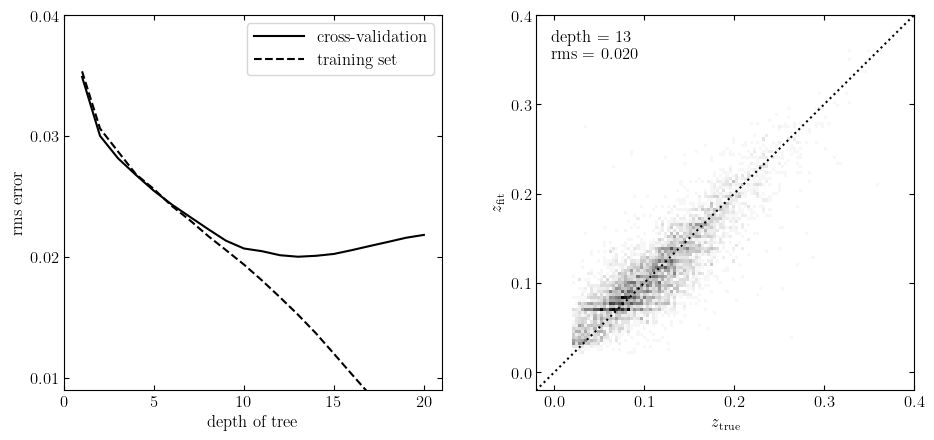

In [6]:
# Compute the cross-validation scores for several tree depths
depth = np.arange(1, 21)
rms_test = np.zeros(len(depth))
rms_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

for i, d in enumerate(depth):
    clf = DecisionTreeRegressor(max_depth=d, random_state=0)
    clf.fit(mag_train, z_train)

    z_fit_train = clf.predict(mag_train)
    z_fit = clf.predict(mag_test)
    rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
    rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

    if rms_test[i] <= rms_test[i_best]:
        i_best = i
        z_fit_best = z_fit

best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# first panel: cross-validation
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.legend(loc=1)

# second panel: best-fit results
ax = fig.add_subplot(122)
edges = np.linspace(z_test.min(), z_test.max(), 101)
H, zs_bins, zp_bins = np.histogram2d(z_test, z_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[zs_bins[0], zs_bins[-1], zs_bins[0], zs_bins[-1]],
           cmap=plt.cm.binary)
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

## Random-forest regression

In [7]:
from sklearn.ensemble import RandomForestRegressor
from astroML.utils.decorators import pickle_results

@pickle_results: using precomputed results from './models/photoz_forest.pkl'


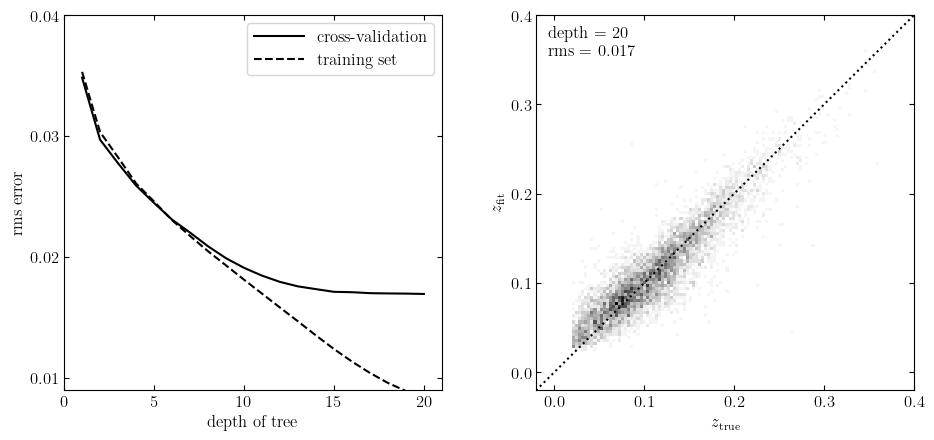

In [9]:
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('./models/photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best


depth = np.arange(1, 21)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)

edges = np.linspace(z_test.min(), z_test.max(), 101)
H, zs_bins, zp_bins = np.histogram2d(z_test, z_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[zs_bins[0], zs_bins[-1], zs_bins[0], zs_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

## Gradient boosting

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

@pickle_results: computing results and saving to 'models/photoz_boosting.pkl'


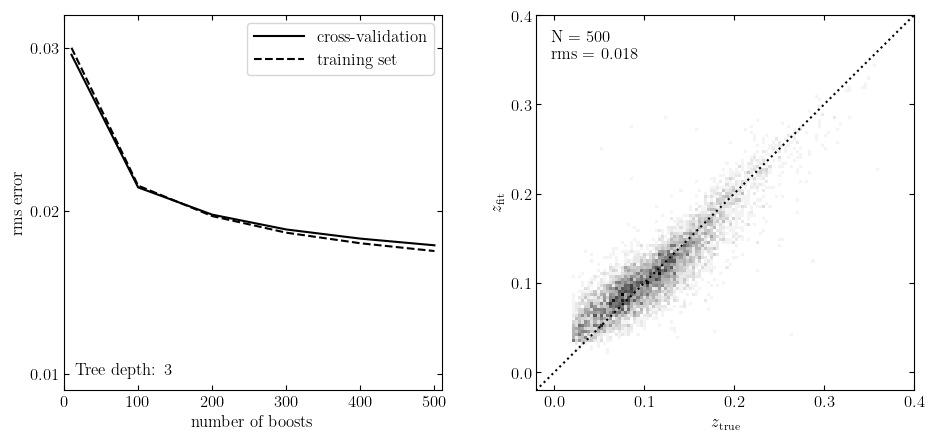

In [11]:
@pickle_results('models/photoz_boosting.pkl')
def compute_photoz_forest(N_boosts):
    rms_test = np.zeros(len(N_boosts))
    rms_train = np.zeros(len(N_boosts))
    i_best = 0
    z_fit_best = None

    for i, Nb in enumerate(N_boosts):
        try:
            # older versions of scikit-learn
            clf = GradientBoostingRegressor(n_estimators=Nb, learn_rate=0.1,
                                            max_depth=3, random_state=0)
        except TypeError:
            clf = GradientBoostingRegressor(n_estimators=Nb, learning_rate=0.1,
                                            max_depth=3, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best

N_boosts = (10, 100, 200, 300, 400, 500)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(N_boosts)
best_N = N_boosts[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(N_boosts, rms_test, '-k', label='cross-validation')
ax.plot(N_boosts, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('number of boosts')
ax.set_ylabel('rms error')
ax.set_xlim(0, 510)
ax.set_ylim(0.009,  0.032)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

ax.text(0.03, 0.03, "Tree depth: 3",
        ha='left', va='bottom', transform=ax.transAxes)

# right panel: plot best fit
ax = fig.add_subplot(122)
edges = np.linspace(z_test.min(), z_test.max(), 101)
H, zs_bins, zp_bins = np.histogram2d(z_test, z_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[zs_bins[0], zs_bins[-1], zs_bins[0], zs_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "N = %i\nrms = %.3f" % (best_N, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))


What happens when we make the trees bigger? 

@pickle_results: computing results and saving to 'models/photoz_boosting2.pkl'


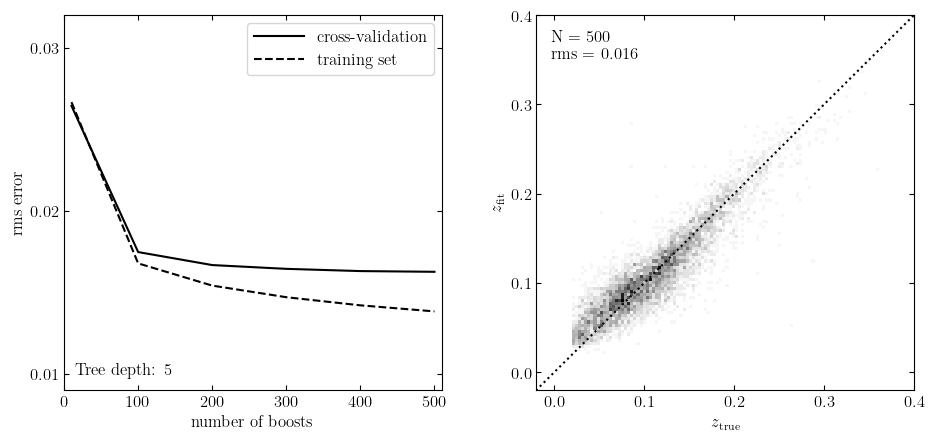

In [13]:
@pickle_results('models/photoz_boosting2.pkl')
def compute_photoz_forest(N_boosts):
    rms_test = np.zeros(len(N_boosts))
    rms_train = np.zeros(len(N_boosts))
    i_best = 0
    z_fit_best = None

    for i, Nb in enumerate(N_boosts):
        try:
            # older versions of scikit-learn
            clf = GradientBoostingRegressor(n_estimators=Nb, learn_rate=0.1,
                                            max_depth=6, random_state=0)
        except TypeError:
            clf = GradientBoostingRegressor(n_estimators=Nb, learning_rate=0.1,
                                            max_depth=6, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best

N_boosts = (10, 100, 200, 300, 400, 500)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(N_boosts)
best_N = N_boosts[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(N_boosts, rms_test, '-k', label='cross-validation')
ax.plot(N_boosts, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('number of boosts')
ax.set_ylabel('rms error')
ax.set_xlim(0, 510)
ax.set_ylim(0.009,  0.032)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

ax.text(0.03, 0.03, "Tree depth: 6",
        ha='left', va='bottom', transform=ax.transAxes)

# right panel: plot best fit
ax = fig.add_subplot(122)
edges = np.linspace(z_test.min(), z_test.max(), 101)
H, zs_bins, zp_bins = np.histogram2d(z_test, z_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[zs_bins[0], zs_bins[-1], zs_bins[0], zs_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "N = %i\nrms = %.3f" % (best_N, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))


The training takes much longer... 
but we get slightly more precise results (compare rms).

## TASK 1 (bonus): Test another algorithm of your choice (e.g. an MLP)! Do you get better results?

To start off, try to follow the [sklearn doc page](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and implement an MLP regressor for this dataset:

In [17]:
from sklearn.neural_network import MLPRegressor